# Lab12: Deep Deterministic Policy Gradient (DDPG) for Continuous Control

In this lab, you will implement and train a **Deep Deterministic Policy Gradient (DDPG)** agent to solve a **continuous control task** using the MuJoCo physics simulator.  
The target environment is:

> **Hopper-v4** — a one-legged robot that must learn to hop forward as fast and as stably as possible.

## 1. Environment: Hopper-v4

The [Hopper environment](https://gymnasium.farama.org/environments/mujoco/hopper/) is a physics-based locomotion task simulated using **MuJoCo**.

- **Observation Space:** 11-dimensional continuous state  
- **Action Space:** 3-dimensional continuous torque control  
- **Objective:** Move forward as fast as possible without falling  
- **Episode Ends When:** The robot falls or becomes unstable  

This task represents a realistic robotic control problem with:
- Nonlinear dynamics  
- High-dimensional state space  
- Continuous actions  
- Long-term credit assignment  

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

env = gym.make("Hopper-v4", render_mode="rgb_array")
print("Env id:", env.spec.id)  
obs, info = env.reset(seed=0)

frames = []
num_steps = 300

for t in range(num_steps):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)

    frame = env.render()
    frames.append(frame.copy())   

    if terminated or truncated:
        obs, info = env.reset()

env.close()
print("Collected frames:", len(frames))

def show_frame(i):
    plt.figure(figsize=(4, 4))
    plt.imshow(frames[i])
    plt.axis("off")
    plt.title(f"Hopper-v4 frame {i}")
    plt.show()

interact(
    show_frame,
    i=IntSlider(0, min=0, max=len(frames)-1, step=1, description="Frame")
)

Env id: Hopper-v4
Collected frames: 300


interactive(children=(IntSlider(value=0, description='Frame', max=299), Output()), _dom_classes=('widget-inter…

<function __main__.show_frame(i)>

## 2. Background

Many real-world control problems involve **continuous actions**, such as:
- Robot joint torques  
- Vehicle steering and acceleration  
- Control forces in physical systems  

Classical Deep Q-Networks (DQN) cannot be directly applied to these problems because they require **discrete** action spaces.  
DDPG extends Q-learning to **continuous control** by combining:

- A **policy network (Actor)** that outputs continuous actions.
- A **value network (Critic)** that estimates the Q-function.
- **Target networks** for stable training.
- A **replay buffer** for off-policy learning.

DDPG is one of the foundational algorithms for continuous reinforcement learning and serves as the basis for more advanced methods such as **TD3** and **SAC**.


## 3. Algorithm Implementation : DDPG

DDPG consists of the following components:

- **Actor Network**  
  Outputs a deterministic continuous action given a state.

- **Critic Network**  
  Estimates the Q-value of state–action pairs.

- **Target Networks**  
  Slowly updated copies of the actor and critic for stable learning.

- **Replay Buffer**  
  Stores past transitions for off-policy training.

- **Exploration Noise**  
  Added to the actor’s output during training for sufficient exploration.



In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import time

## Hints for Implementing the Actor and Critic Networks

### Actor Network (Policy)

- The **Actor maps a state to a continuous action**.
- Its input dimension must match the **observation space dimension**.
- Its output dimension must match the **action space dimension**.
- Use **fully connected layers with ReLU activations**.
- Since actions must lie in a **bounded continuous range**, the **final layer should use `tanh`**.
- The output must be **scaled by the maximum action value** of the environment.

In [4]:
class Actor(nn.Module):
    def __init__(self, obs_dim, act_dim, max_action):
        super().__init__()
        self.net = nn.Sequential(
             # your time to work on it 
        )
        self.max_action = max_action

    def forward(self, x):
        return self.max_action * self.net(x)

### Critic Network (Q-function)


- The **Critic estimates Q(s, a)**.
- Its input is the **concatenation of the state vector and the action vector**.
- The output is a **single scalar value** (the Q-value).
- The first linear layer must accept:


In [8]:
class Critic(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            # your time to work on it 
        )

    def forward(self, s, a):
        return self.net(torch.cat([s, a], dim=1))

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity=1_000_000):
        self.buffer = deque(maxlen=capacity)

    def push(self, s, a, r, s2, d):
        self.buffer.append((s, a, r, s2, d))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s2, d = map(np.array, zip(*batch))
        return (
            torch.FloatTensor(s),
            torch.FloatTensor(a),
            torch.FloatTensor(r).unsqueeze(1),
            torch.FloatTensor(s2),
            torch.FloatTensor(d).unsqueeze(1),
        )

    def __len__(self):
        return len(self.buffer)

In [5]:
env = gym.make("Hopper-v4")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

actor = Actor(obs_dim, act_dim, max_action).to(device)
critic = Critic(obs_dim, act_dim).to(device)
actor_target = Actor(obs_dim, act_dim, max_action).to(device)
critic_target = Critic(obs_dim, act_dim).to(device)

actor_target.load_state_dict(actor.state_dict())
critic_target.load_state_dict(critic.state_dict())

actor_opt = optim.Adam(actor.parameters(), lr=1e-4)
critic_opt = optim.Adam(critic.parameters(), lr=1e-3)

buffer = ReplayBuffer()

gamma = 0.99
tau = 0.005
batch_size = 256
exploration_noise = 0.1

total_steps = 300_000
warmup_steps = 10_000

state, _ = env.reset()
episode_reward = 0
episode_length = 0

In [6]:
SAVE_PATH = "ddpg_hopper_actor_class.pth"

### Hints for the Four DDPG TODOs

#### Choose a **continuous action** from the current policy, plus **exploration noise**.

- Convert the current state `state` to a PyTorch tensor on the correct device and add a batch dimension.
- Pass it through the **actor network** to get a deterministic action.
- During early training, you may want to use **pure random actions** (e.g., `env.action_space.sample()`).
- After warmup, add **Gaussian noise** to the actor output:
$$
  a_{\text{noisy}} = \pi_{\theta}(s) + \mathcal{N}(0, \sigma^2)
$$
- Finally, **clip** the action into the valid range using `np.clip`.


#### Compute the **Bellman target** for the critic.

Hints:
- Use the **target networks** here (`actor_target`, `critic_target`), not the main networks.
- First, get the **next action** from the target actor:
$$
  a' = \pi_{\theta'}(s')
$$
- Then feed `(s', a')` into the **target critic** to obtain:
$$
  Q_{\phi'}(s', a')
$$
- The target Q-value is:
$$
  y = r + \gamma (1 - d)\, Q_{\phi'}(s', a')
$$
  where:
  - $ r $ is the reward
  - $ d $ is the done flag (1 if terminal, 0 otherwise)
  - $ \gamma $ is the discount factor


#### Train the critic to match the Bellman target using **MSE loss**.

Hints:
- You already have:
  - `q_val = critic(s, a)` → current critic prediction
  - `q_target` → from step (2), treated as a constant (no gradient)
- Use **mean squared error**:
  $$
  \mathcal{L}_{\text{critic}} = \frac{1}{N} \sum_i (Q_{\phi}(s_i, a_i) - y_i)^2
  $$
- In PyTorch, use `nn.MSELoss()` or `(q_val - q_target).pow(2).mean()`.


#### Update the actor to choose actions that the critic thinks are **high-value**.
- For the actor, we **do not** use rewards directly.
- We want to **maximize** $ Q(s, \pi_{\theta}(s))$.
- Equivalently, we **minimize** the negative Q-value:
  $$
  \mathcal{L}_{\text{actor}} = -\,\mathbb{E}_s \big[ Q_{\phi}(s, \pi_{\theta}(s)) \big]
  $$
- Implementation steps:
  1. Compute actions from the current actor: `a_pi = actor(s)`
  2. Evaluate these actions with the current critic: `critic(s, a_pi)`
  3. Take the **negative mean** of that value as the actor loss.

In [7]:
episode = 0

for step in range(total_steps):

    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    action = actor(state_tensor).cpu().data.numpy().flatten()

    if step < warmup_steps:
        action = env.action_space.sample()
    else:
        action = # 1. Your time to work on it 

    action = np.clip(action, -max_action, max_action)

    # --- step env ---
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    buffer.push(state, action, reward, next_state, float(done))

    state = next_state
    episode_reward += reward
    episode_length += 1
    
    # --- reset if done ---
    if done:
        print(f"Episode {episode} | Reward: {episode_reward:.1f} | Lenght: {episode_length}")
        state, _ = env.reset()
        episode_reward = 0
        episode_length = 0
        episode += 1

    # --- update ---
    if len(buffer) > batch_size:

        s, a, r, s2, d = buffer.sample(batch_size)
        s = s.to(device)
        a = a.to(device)
        r = r.to(device)
        s2 = s2.to(device)
        d = d.to(device)

        # Critic update
        with torch.no_grad():
            a2 = actor_target(s2)
            q_target = # 2. Your time to work on it 

        q_val = critic(s, a)
        critic_loss = # 3. Your time to work on it  

        critic_opt.zero_grad()
        critic_loss.backward()
        critic_opt.step()

        # Actor update
        actor_loss = # 4. Your time to work on it 

        actor_opt.zero_grad()
        actor_loss.backward()
        actor_opt.step()

        # Target update
        for p, p_t in zip(actor.parameters(), actor_target.parameters()):
            p_t.data.copy_(tau * p.data + (1 - tau) * p_t.data)

        for p, p_t in zip(critic.parameters(), critic_target.parameters()):
            p_t.data.copy_(tau * p.data + (1 - tau) * p_t.data)

    # --- occasionally show progress ---
    if step % 10_000 == 0:
        print(f"Step {step}/{total_steps}")
        torch.save(actor.state_dict(), SAVE_PATH)
        
print("Training finished and model saved!")

Step 0/300000
Episode 0 | Reward: 13.0 | Lenght: 20
Episode 1 | Reward: 13.7 | Lenght: 16
Episode 2 | Reward: 30.8 | Lenght: 31
Episode 3 | Reward: 61.9 | Lenght: 56
Episode 4 | Reward: 11.2 | Lenght: 17
Episode 5 | Reward: 3.3 | Lenght: 16
Episode 6 | Reward: 15.2 | Lenght: 22
Episode 7 | Reward: 12.8 | Lenght: 14
Episode 8 | Reward: 10.8 | Lenght: 15
Episode 9 | Reward: 11.2 | Lenght: 14
Episode 10 | Reward: 6.3 | Lenght: 10
Episode 11 | Reward: 9.3 | Lenght: 14
Episode 12 | Reward: 43.2 | Lenght: 35
Episode 13 | Reward: 40.5 | Lenght: 40
Episode 14 | Reward: 70.9 | Lenght: 58
Episode 15 | Reward: 36.7 | Lenght: 49
Episode 16 | Reward: 15.2 | Lenght: 37


KeyboardInterrupt: 

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

env = gym.make("Hopper-v4", render_mode="rgb_array")
print("Env id:", env.spec.id)  
obs, info = env.reset(seed=0)

frames = []
num_steps = 300

for t in range(num_steps):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)

    frame = env.render()
    frames.append(frame.copy())   

    if terminated or truncated:
        obs, info = env.reset()

env.close()
print("Collected frames:", len(frames))

def show_frame(i):
    plt.figure(figsize=(4, 4))
    plt.imshow(frames[i])
    plt.axis("off")
    plt.title(f"Hopper-v4 frame {i}")
    plt.show()

interact(
    show_frame,
    i=IntSlider(0, min=0, max=len(frames)-1, step=1, description="Frame")
)

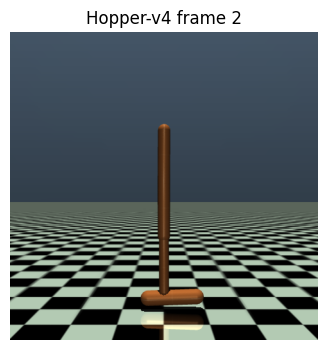

In [17]:
show_frame(2)